In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
reg_data_df = pd.read_csv('/Users/pavel/Documents/Study/Карпов Курс/jupyter-p-chernik/shared/problem1-reg_data.csv')
auth_data_df = pd.read_csv('/Users/pavel/Documents/Study/Карпов Курс/jupyter-p-chernik/shared/problem1-auth_data.csv')

In [3]:
reg_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 1 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   reg_ts;uid  1000000 non-null  object
dtypes: object(1)
memory usage: 7.6+ MB


In [4]:
auth_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 1 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   auth_ts;uid  object
dtypes: object(1)
memory usage: 73.3+ MB


In [5]:
# Разделяем столбец 'reg_ts;uid' на два столбца 'reg_ts', 'uid' и удаляем его.

reg_data_df[['reg_ts', 'uid']] = reg_data_df['reg_ts;uid'].str.split(';', expand=True)
reg_data_df = reg_data_df.drop(columns=['reg_ts;uid'])

In [6]:
# Разделяем столбец 'auth_ts;uid' на два столбца 'auth_ts', 'uid' и удаляем его.

auth_data_df[['auth_ts', 'uid']] = auth_data_df['auth_ts;uid'].str.split(';', expand=True)
auth_data_df = auth_data_df.drop(columns=['auth_ts;uid'])

In [7]:
reg_data_df.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [8]:
auth_data_df.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [9]:
# Подсчитываем нулевые значения

reg_data_df.isnull().sum()

reg_ts    0
uid       0
dtype: int64

In [10]:
# Подсчитываем нулевые значения

auth_data_df.isnull().sum()

auth_ts    0
uid        0
dtype: int64

In [11]:
# Подсчитываем пропущенные значения

reg_data_df.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [12]:
# Подсчитываем пропущенные значения

auth_data_df.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [13]:
# Преобразовываем значения из Unix в формат даты 

reg_data_df['reg_ts'] = pd.to_datetime(reg_data_df['reg_ts'], unit='s').dt.floor('d')
auth_data_df['auth_ts'] = pd.to_datetime(auth_data_df['auth_ts'], unit='s').dt.floor('d')

In [14]:
reg_data_df.dtypes

reg_ts    datetime64[ns]
uid               object
dtype: object

In [15]:
auth_data_df.dtypes

auth_ts    datetime64[ns]
uid                object
dtype: object

In [16]:
# Объединяем датафреймы в один

data = reg_data_df.merge(auth_data_df, on='uid')

In [17]:
data.head()

,reg_ts,uid,auth_ts
0,1998-11-18,1,1998-11-18
1,1999-07-22,2,1999-07-22
2,1999-07-22,2,1999-07-25
3,1999-07-22,2,1999-07-31
4,1999-07-22,2,1999-08-05


In [18]:
data.query('reg_ts == "2020-01-01"').nunique()

reg_ts        1
uid        1061
auth_ts     267
dtype: int64

In [19]:
def calculate_retention(data, start_date, period):
    """
    Рассчитывает Retention для пользователей на каждый день возврата относительно даты регистрации.

    data: DataFrame с данными о регистрации и активности пользователей.
    start_date: Начальная дата рассмотрения когорты.
    period: Период в днях для расчета Retention.
    
    period_end_date: Устанавливаем период в днях после начальной даты.
    data_filtered: Создаёт отфильтрованный DataFrame по нужному периоду
    ret_df: Сгруппированный DataFrame по дням регистрации и возврата
    
    :return: DataFrame с Retention для каждого дня возврата.
    """
    
    period_end_date = pd.to_datetime(start_date) + pd.DateOffset(days=period)
    data_filtered = data[(data['reg_ts'] >= start_date) & (data['auth_ts'] <= period_end_date)].copy() 
    data_filtered['return_day'] = ((data_filtered['auth_ts'] - data_filtered['reg_ts']).dt.days).clip(0, period)    
    ret_df = data_filtered.groupby(['reg_ts', 'return_day']).size().unstack(fill_value=0)
    cohort_sizes = ret_df.iloc[:, 0]
    
    for day in range(1, period + 1):
        ret_df[day] = (ret_df[day] / cohort_sizes) * 100
    
    ret_df = round(ret_df, 2)
    
    ret_df.rename(columns={0: 'cohort_size'}, inplace=True)
    
    return ret_df

In [20]:
docstring = calculate_retention.__doc__
print(docstring)


    Рассчитывает Retention для пользователей на каждый день возврата относительно даты регистрации.

    data: DataFrame с данными о регистрации и активности пользователей.
    start_date: Начальная дата рассмотрения когорты.
    period: Период в днях для расчета Retention.
    
    period_end_date: Устанавливаем период в днях после начальной даты.
    data_filtered: Создаёт отфильтрованный DataFrame по нужному периоду
    ret_df: Сгруппированный DataFrame по дням регистрации и возврата
    
    :return: DataFrame с Retention для каждого дня возврата.
    


In [21]:
# Вызов функции для расчета Retention с возможностью установки необходимого периода

ret_df = calculate_retention(data, '2020-01-01', 14)

In [22]:
ret_df

return_day,cohort_size,1,2,3,4,5,6,7,8,9,10,11,12,13,14
reg_ts,,,,,,,,,,,,,,,
2020-01-01,1061,2.64,4.52,3.39,5.66,5.84,7.54,5.00,4.43,4.43,5.37,6.50,4.62,4.90,4.81
2020-01-02,1063,2.35,4.52,5.17,4.80,5.83,7.71,5.93,5.64,5.27,5.64,5.64,4.52,4.52,0.00
2020-01-03,1065,2.35,3.38,4.41,4.51,6.85,7.51,5.45,4.51,4.23,5.26,5.82,5.54,0.00,0.00
2020-01-04,1067,1.50,4.50,5.06,5.34,5.72,7.03,5.44,4.22,4.87,4.78,5.44,0.00,0.00,0.00
2020-01-05,1069,1.96,4.49,4.58,4.40,4.77,7.86,5.24,3.93,5.43,4.12,0.00,0.00,0.00,0.00
2020-01-06,1070,2.90,4.49,4.95,3.83,4.67,6.64,5.89,5.23,5.05,0.00,0.00,0.00,0.00,0.00
2020-01-07,1072,1.87,4.85,4.38,6.44,5.04,8.49,5.13,5.69,0.00,0.00,0.00,0.00,0.00,0.00
2020-01-08,1074,2.23,4.00,4.28,5.12,5.03,8.47,5.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2020-01-09,1076,1.86,4.00,5.48,4.46,6.04,6.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


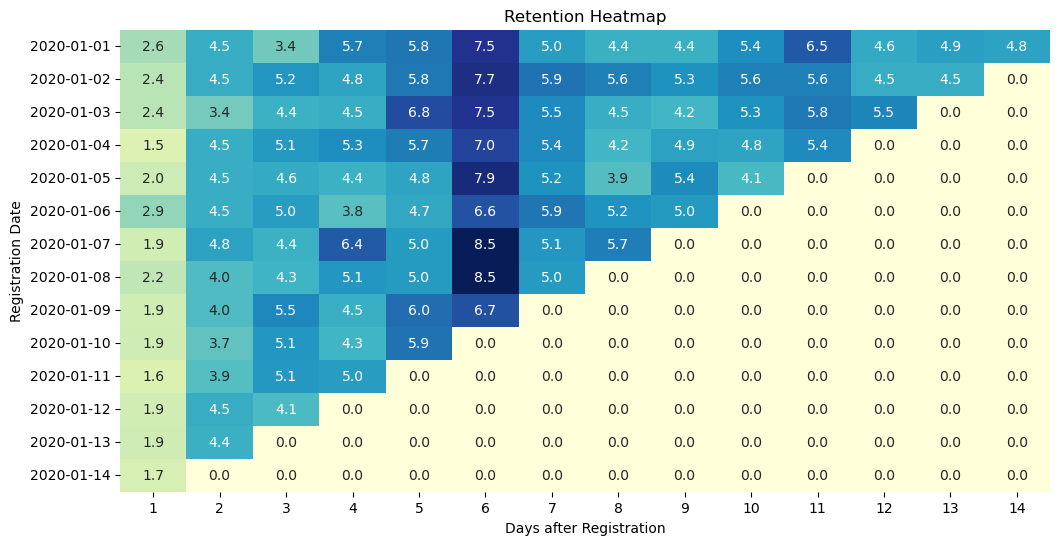

In [23]:
# Делаем визуализацию при помощи тепловой карты

plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(ret_df.iloc[:-1, 1:], annot=True, cmap='YlGnBu', fmt=".1f", cbar=False)

date_labels = [item.get_text() for item in heatmap.get_yticklabels()]
formatted_date_labels = [pd.to_datetime(label).strftime('%Y-%m-%d') for label in date_labels]
heatmap.set_yticklabels(formatted_date_labels)

plt.ylabel('Registration Date')
plt.xlabel('Days after Registration') 
plt.title('Retention Heatmap')
plt.show()